In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import utils

import tensorflow as tf

In [2]:
# Access to data through google drive

from google.colab import drive
drive.mount('/content/drive')
data_access = '/content/drive/My Drive/Projects in ML&AI HW5 Data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Task 1: Classification

The problem chosen is to classify images of pokemon based on their primary type. The data used contains each pokemon along with one picture of them, their primary type, and their secondary type.

## Load data

Source: [Pokemon Image Dataset](https://www.kaggle.com/datasets/vishalsubbiah/pokemon-images-and-types)

In [2]:
pokemon = pd.read_csv(data_access + 'pokemon.csv')

pokemon.head()

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN


In [3]:
pokemon_types = pokemon['Type1'].unique()

In [4]:
filenames = data_access + 'images/' + pokemon['Name'] + '.png'
images = filenames.apply(mpimg.imread)

In [5]:
image_data = np.empty((len(images), 120, 120, 4))
for i in range(len(images)):
    if images[i].shape[2] == 3:
        image_data[i] = np.concatenate((images[i], np.ones((120, 120, 1))), axis=-1)
    else:
        image_data[i] = images[i]

image_data.shape

(809, 120, 120, 4)

## EDA + Preprocessing

### Type data

In [6]:
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 809 entries, 0 to 808
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    809 non-null    object
 1   Type1   809 non-null    object
 2   Type2   405 non-null    object
dtypes: object(3)
memory usage: 19.1+ KB


In [7]:
pokemon.describe()

,Name,Type1,Type2
count,809,809,405
unique,809,18,18
top,bulbasaur,Water,Flying
freq,1,114,95


In [8]:
SECONDARY_TYPE = 0.5    # 0.5 for distinction between primary and secondary type, 1 otherwise

pokemon_data = pd.get_dummies(pokemon, columns=['Type1'], prefix='1_', prefix_sep='')
pokemon_data = pd.get_dummies(pokemon_data, columns=['Type2'], prefix='2_', prefix_sep='')
# pokemon_data['Type2'] = pokemon_data['Type2'].fillna(0)
# for i in range(len(pokemon_data['Type2'])):
#     sec_type = pokemon_data['Type2'].loc[i]
#     if sec_type != 0:
#         pokemon_data[sec_type].loc[i] += SECONDARY_TYPE

# pokemon_data = pokemon_data.drop(columns=['Type2'])

In [9]:
pokemon_data.describe()

,1_Bug,1_Dark,1_Dragon,1_Electric,1_Fairy,1_Fighting,1_Fire,1_Flying,1_Ghost,1_Grass,...,2_Ghost,2_Grass,2_Ground,2_Ice,2_Normal,2_Poison,2_Psychic,2_Rock,2_Steel,2_Water
count,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,...,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000
mean,0.088999,0.035847,0.033375,0.049444,0.022250,0.035847,0.065513,0.003708,0.033375,0.096415,...,0.019778,0.023486,0.039555,0.013597,0.004944,0.039555,0.035847,0.017305,0.028430,0.021014
std,0.284918,0.186023,0.179724,0.216927,0.147586,0.186023,0.247582,0.060820,0.179724,0.295343,...,0.139321,0.151534,0.195032,0.115882,0.070186,0.195032,0.186023,0.130487,0.166301,0.143518
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
pokemon_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 809 entries, 0 to 808
Data columns (total 37 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Name        809 non-null    object
 1   1_Bug       809 non-null    uint8 
 2   1_Dark      809 non-null    uint8 
 3   1_Dragon    809 non-null    uint8 
 4   1_Electric  809 non-null    uint8 
 5   1_Fairy     809 non-null    uint8 
 6   1_Fighting  809 non-null    uint8 
 7   1_Fire      809 non-null    uint8 
 8   1_Flying    809 non-null    uint8 
 9   1_Ghost     809 non-null    uint8 
 10  1_Grass     809 non-null    uint8 
 11  1_Ground    809 non-null    uint8 
 12  1_Ice       809 non-null    uint8 
 13  1_Normal    809 non-null    uint8 
 14  1_Poison    809 non-null    uint8 
 15  1_Psychic   809 non-null    uint8 
 16  1_Rock      809 non-null    uint8 
 17  1_Steel     809 non-null    uint8 
 18  1_Water     809 non-null    uint8 
 19  2_Bug       809 non-null    uint8 
 20  2_Dark    

In [11]:
pokemon_labels = pokemon_data.drop(columns=['Name'])

pokemon_labels.head()

,1_Bug,1_Dark,1_Dragon,1_Electric,1_Fairy,1_Fighting,1_Fire,1_Flying,1_Ghost,1_Grass,...,2_Ghost,2_Grass,2_Ground,2_Ice,2_Normal,2_Poison,2_Psychic,2_Rock,2_Steel,2_Water
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


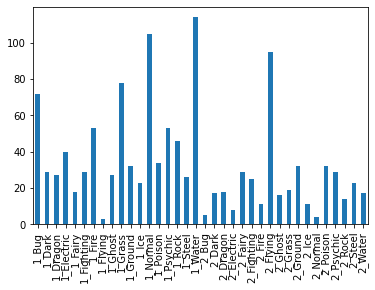

In [12]:
pokemon_labels.agg('sum').plot.bar()

### Image data
Image EDA source: [Exploratory Data Analysis Ideas for Image Classification](https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2)

In [13]:
image_groups = {t: [] for t in pokemon_types}
image_groups2 = {t: [] for t in pokemon_types}
for i in range(len(pokemon)):
    image_groups[pokemon['Type1'].loc[i]].append(i)
    if pokemon['Type2'].loc[i] in image_groups:
        image_groups[pokemon['Type2'].loc[i]].append(i)
        image_groups2[pokemon['Type2'].loc[i]].append(i)

In [14]:
image_data[image_groups['Bug']].shape

(77, 120, 120, 4)

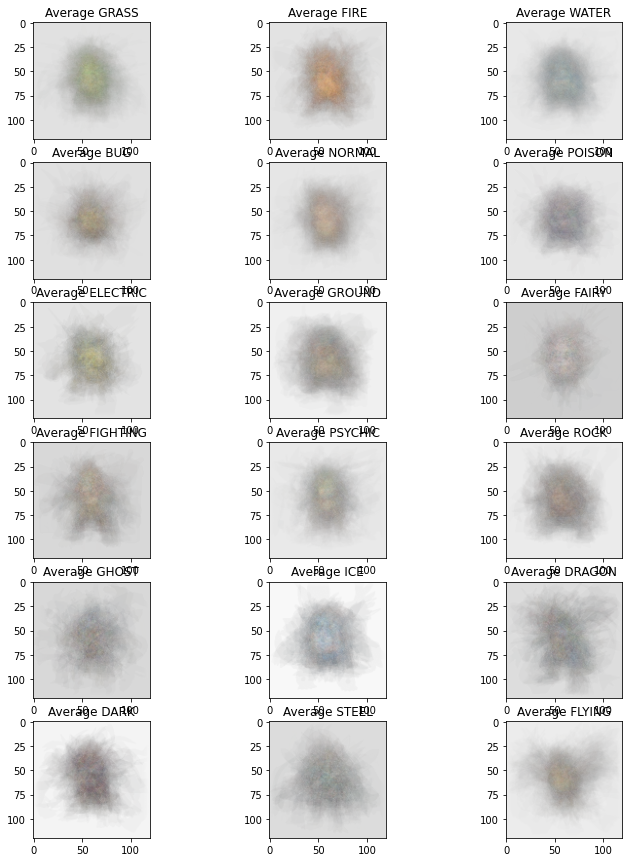

In [15]:
def find_mean_img(full_mat, title, axes, idx, size=(120, 120, 4)):
    # calculate the average
    mean_img = np.mean(np.asarray(full_mat), axis=0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)

    axarr[idx[0], idx[1]].imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    axarr[idx[0], idx[1]].set_title(f'Average {title}')

    return mean_img

images_means = {t: None for t in pokemon_types}
f, axarr = plt.subplots(6, 3, figsize=(12, 15))
for i in range(len(pokemon_types)):
    row, col = i // 3, i % 3
    images_means[pokemon_types[i]] = find_mean_img(image_data[image_groups[pokemon_types[i]]],
                                                   pokemon_types[i].upper(),
                                                   axarr, (row, col))
plt.show()

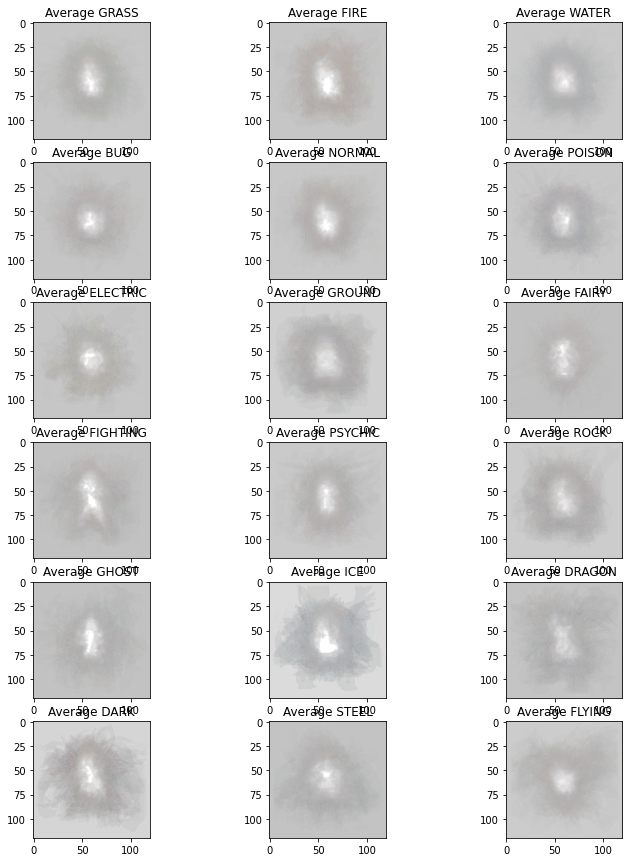

In [16]:
def find_std_img(full_mat, title, axes, idx, size=(120, 120, 4)):
    # calculate the average
    std_img = np.std(np.asarray(full_mat), axis=0)
    # reshape it back to a matrix
    std_img = std_img.reshape(size)

    axarr[idx[0], idx[1]].imshow(std_img, vmin=0, vmax=255, cmap='Greys_r')
    axarr[idx[0], idx[1]].set_title(f'Average {title}')

    return std_img

images_stds = {t: None for t in pokemon_types}
f, axarr = plt.subplots(6, 3, figsize=(12, 15))
for i in range(len(pokemon_types)):
    row, col = i // 3, i % 3
    images_stds[pokemon_types[i]] = find_std_img(image_data[image_groups[pokemon_types[i]]],
                                                   pokemon_types[i].upper(),
                                                   axarr, (row, col))
plt.show()

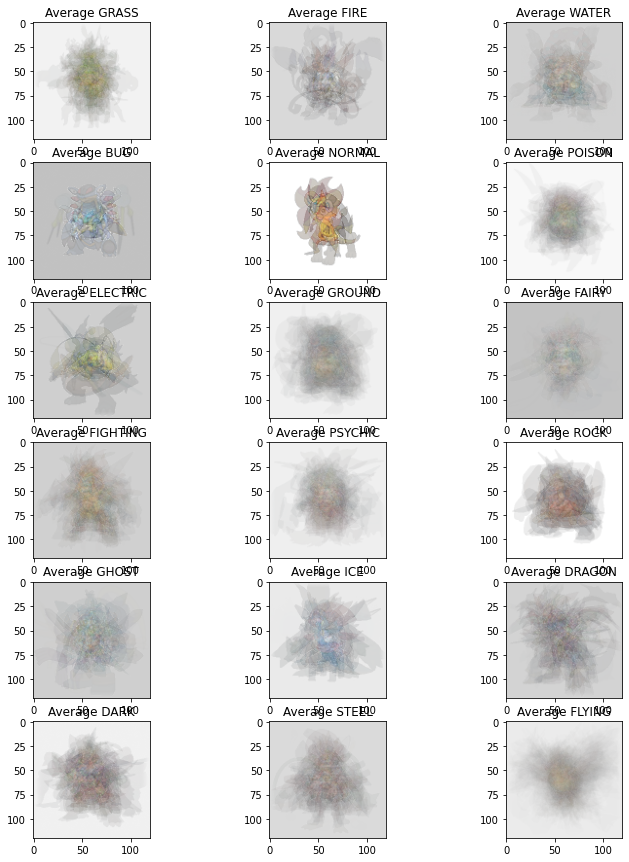

In [17]:
def find_mean_img(full_mat, title, axes, idx, size=(120, 120, 4)):
    # calculate the average
    mean_img = np.mean(np.asarray(full_mat), axis=0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)

    axarr[idx[0], idx[1]].imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    axarr[idx[0], idx[1]].set_title(f'Average {title}')

    return mean_img

images_means = {t: None for t in pokemon_types}
f, axarr = plt.subplots(6, 3, figsize=(12, 15))
for i in range(len(pokemon_types)):
    row, col = i // 3, i % 3
    images_means[pokemon_types[i]] = find_mean_img(image_data[image_groups2[pokemon_types[i]]],
                                                   pokemon_types[i].upper(),
                                                   axarr, (row, col))
plt.show()

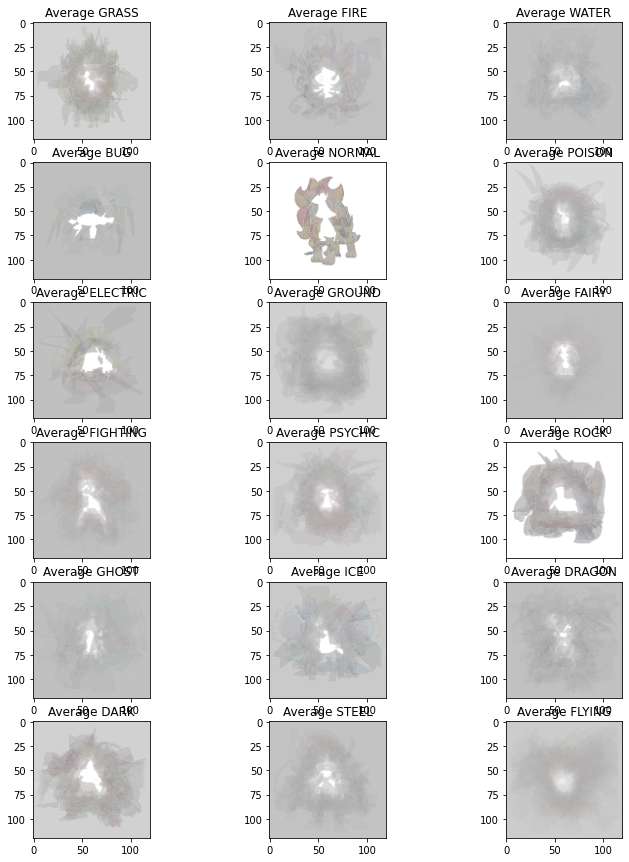

In [18]:
def find_std_img(full_mat, title, axes, idx, size=(120, 120, 4)):
    # calculate the average
    std_img = np.std(np.asarray(full_mat), axis=0)
    # reshape it back to a matrix
    std_img = std_img.reshape(size)

    axarr[idx[0], idx[1]].imshow(std_img, vmin=0, vmax=255, cmap='Greys_r')
    axarr[idx[0], idx[1]].set_title(f'Average {title}')

    return std_img

images_stds = {t: None for t in pokemon_types}
f, axarr = plt.subplots(6, 3, figsize=(12, 15))
for i in range(len(pokemon_types)):
    row, col = i // 3, i % 3
    images_stds[pokemon_types[i]] = find_std_img(image_data[image_groups2[pokemon_types[i]]],
                                                   pokemon_types[i].upper(),
                                                   axarr, (row, col))
plt.show()

In [19]:
# Less points and harder to separate pokemon by secondary type

In [20]:
# Confirm that the alpha layer is necessary (RGBA vs RGB)
np.unique(image_data[:, :, :, 3])

array([0.        , 0.06666667, 0.13333334, 0.2       , 0.26666668,
       0.33333334, 0.40000001, 0.46666667, 0.53333336, 0.60000002,
       0.66666669, 0.73333335, 0.80000001, 0.86666667, 0.93333334,
       1.        ])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(image_data, pokemon_labels.to_numpy(), test_size=0.2)
y_train = np.asarray(y_train, dtype=np.float32)
y_test = np.asarray(y_test, dtype=np.float32)

## CNN

Architecture:
* Convolution layer (8 filters, 2x2 kernel, stride of 2, even padding (output size = input size), ReLU activation)
* Max pooling (2x2 pooling, even padding)
* Dropout layer (20% drop)
* Convolution layer (16 filters, 2x2 kernel, stride of 2, even padding, ReLU activation)
* Dropout layer (20% drop)
* Fully-connected output layer (18 output cells, softmax activation)

This problem faced a huge impact from overfitting, as the training accuracy increased as expected, but the testing accuracy converged at only about 20%. To combat this, I tried to simplify the model as much as possible, which is why I only used 2 convolution layers with few filters, as well as a single output layer rather than multiple. I also added dropout layers and regularization in the compilation of the model for this reason. Unfortunately, these changes did not lead to much improvement, and my best guess of this is that the large number of class labels and the complexity of the images cause low testing accuracy, even though the model can learn the training set well.

### Single-label classification (only primary type)

In [22]:
y_train2 = y_train[:, :18]
y_test2 = y_test[:, :18]

In [23]:
cnn_model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(8, 2, 2, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(padding='same'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(16, 2, 2, padding='same', activation='relu'),
    #tf.keras.layers.MaxPool2D(padding='same'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Conv2D(32, 2, 2, padding='same', activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(18, activation='softmax')
])

cnn_model2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001, decay=0.0001),
                  metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [24]:
history2 = cnn_model2.fit(X_train, y_train2, epochs=250, validation_data=(X_test, y_test2))

Epoch 1/250
21/21 [==============================] - 2s 61ms/step - loss: 2.8481 - categorical_accuracy: 0.1113 - val_loss: 2.8184 - val_categorical_accuracy: 0.1481
Epoch 2/250
21/21 [==============================] - 1s 51ms/step - loss: 2.7049 - categorical_accuracy: 0.1638 - val_loss: 2.7802 - val_categorical_accuracy: 0.1420
Epoch 3/250
21/21 [==============================] - 1s 42ms/step - loss: 2.6608 - categorical_accuracy: 0.1762 - val_loss: 2.7626 - val_categorical_accuracy: 0.1481
Epoch 4/250
21/21 [==============================] - 1s 41ms/step - loss: 2.6295 - categorical_accuracy: 0.1577 - val_loss: 2.7644 - val_categorical_accuracy: 0.1358
Epoch 5/250
21/21 [==============================] - 1s 42ms/step - loss: 2.6142 - categorical_accuracy: 0.1607 - val_loss: 2.7612 - val_categorical_accuracy: 0.1543
Epoch 6/250
21/21 [==============================] - 1s 46ms/step - loss: 2.5913 - categorical_accuracy: 0.1685 - val_loss: 2.7608 - val_categorical_accuracy: 0.1481
Epoc

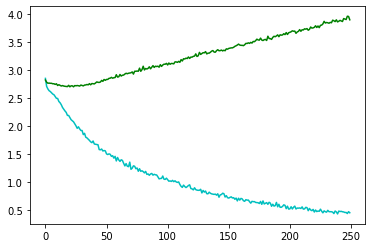

In [25]:
plt.figure(1)
plt.plot(range(250), history2.history['loss'], color='c')
plt.plot(range(250), history2.history['val_loss'], color='g')

plt.show()

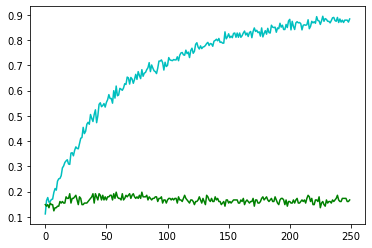

In [26]:
plt.figure(1)
plt.plot(range(250), history2.history['categorical_accuracy'], color='c')
plt.plot(range(250), history2.history['val_categorical_accuracy'], color='g')

plt.show()

### Multi-label classification (primary and secondary types) (decided not to use because of low model performance

In [67]:
class MacroSoftF1(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        tp = tf.reduce_sum(y_pred * y_true, axis=0)
        fp = tf.reduce_sum(y_pred * (1 - y_true), axis=0)
        fn = tf.reduce_sum((1 - y_pred) * y_true, axis=0)
        soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
        cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
        macro_cost = tf.reduce_mean(cost) # average on all labels

        return macro_cost

class MacroF1(tf.keras.metrics.Metric):
    def __init__(self):
        super(MacroF1, self).__init__()
        self.macro_f1 = self.add_weight(name='macro_f1')

    def update_state(self, y_true, y_pred, sample_weight=None):
        thresh = 0.5
        y_pred = tf.cast(tf.greater(y_pred, thresh), tf.float32)
        tp = tf.cast(tf.math.count_nonzero(y_pred * y_true, axis=0), tf.float32)
        fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y_true), axis=0), tf.float32)
        fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y_true, axis=0), tf.float32)
        f1 = 2*tp / (2*tp + fn + fp + 1e-16)
        self.macro_f1 = tf.reduce_mean(f1)

    def result(self):
        return self.macro_f1

In [68]:
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(8, 2, 2, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(padding='same'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(16, 2, 2, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(padding='same'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(32, 2, 2, padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(36, activation='softmax')
])

cnn_model.compile(loss=MacroSoftF1(),
                  optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
                  metrics=[MacroF1()])

In [71]:
history = cnn_model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
21/21 [==============================] - 2s 38ms/step - loss: 0.9769 - macro_f1_6: 0.0000e+00
Epoch 2/100
21/21 [==============================] - 1s 40ms/step - loss: 0.9746 - macro_f1_6: 0.0000e+00
Epoch 3/100
21/21 [==============================] - 1s 39ms/step - loss: 0.9721 - macro_f1_6: 0.0000e+00
Epoch 4/100
21/21 [==============================] - 1s 39ms/step - loss: 0.9697 - macro_f1_6: 0.0000e+00
Epoch 5/100
21/21 [==============================] - 1s 37ms/step - loss: 0.9654 - macro_f1_6: 0.0000e+00
Epoch 6/100
21/21 [==============================] - 1s 39ms/step - loss: 0.9612 - macro_f1_6: 0.0000e+00
Epoch 7/100
21/21 [==============================] - 1s 45ms/step - loss: 0.9557 - macro_f1_6: 0.0000e+00
Epoch 8/100
21/21 [==============================] - 1s 44ms/step - loss: 0.9553 - macro_f1_6: 0.0000e+00
Epoch 9/100
21/21 [==============================] - 1s 44ms/step - loss: 0.9492 - macro_f1_6: 0.0000e+00
Epoch 10/100
21/21 [==========================

In [73]:
new_history = cnn_model.fit(X_train, y_train, epochs=100)

Epoch 1/100
21/21 [==============================] - 1s 46ms/step - loss: 0.8617 - macro_f1_6: 0.1130
Epoch 2/100
21/21 [==============================] - 1s 44ms/step - loss: 0.8742 - macro_f1_6: 0.0556
Epoch 3/100
21/21 [==============================] - 1s 44ms/step - loss: 0.8592 - macro_f1_6: 0.0926
Epoch 4/100
21/21 [==============================] - 1s 45ms/step - loss: 0.8649 - macro_f1_6: 0.0389
Epoch 5/100
21/21 [==============================] - 1s 39ms/step - loss: 0.8733 - macro_f1_6: 0.0278
Epoch 6/100
21/21 [==============================] - 1s 39ms/step - loss: 0.8683 - macro_f1_6: 0.1111
Epoch 7/100
21/21 [==============================] - 1s 41ms/step - loss: 0.8617 - macro_f1_6: 0.0324
Epoch 8/100
21/21 [==============================] - 1s 41ms/step - loss: 0.8598 - macro_f1_6: 0.1111
Epoch 9/100
21/21 [==============================] - 1s 37ms/step - loss: 0.8605 - macro_f1_6: 0.1111
Epoch 10/100
21/21 [==============================] - 1s 40ms/step - loss: 0.8606 

In [74]:
cnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 60, 60, 8)         136       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 8)        0         
 2D)                                                             
                                                                 
 dropout_14 (Dropout)        (None, 30, 30, 8)         0         
                                                                 
 conv2d_15 (Conv2D)          (None, 15, 15, 16)        528       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 8, 8, 16)         0         
 2D)                                                             
                                                                 
 dropout_15 (Dropout)        (None, 8, 8, 16)         

In [75]:
y_hat = cnn_model.predict(X_test)

6/6 [==============================] - 0s 14ms/step


## ResNet50

The ResNet50 model performs worse than the CNN model I built above, most likely due to the complexity of the ResNet50 leading to overfitting, which is especially an issue in this problem, as mentioned above.

In [174]:
res_net = tf.keras.applications.ResNet50(weights=None, input_shape=(120, 120, 4), classes=18)

res_net.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001, decay=0.0001),
                  metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [176]:
# More iterations leads to poor generalization
res_history = res_net.fit(X_train, y_train2, epochs=6, validation_data=(X_test, y_test2))

Epoch 1/6
21/21 [==============================] - 165s 8s/step - loss: 0.3304 - categorical_accuracy: 0.8980 - val_loss: 6.5309 - val_categorical_accuracy: 0.0062
Epoch 2/6
21/21 [==============================] - 196s 9s/step - loss: 0.2893 - categorical_accuracy: 0.9057 - val_loss: 5.8526 - val_categorical_accuracy: 0.0062
Epoch 3/6
21/21 [==============================] - 188s 9s/step - loss: 0.3864 - categorical_accuracy: 0.8810 - val_loss: 5.7233 - val_categorical_accuracy: 0.0123
Epoch 4/6
21/21 [==============================] - 177s 8s/step - loss: 0.5215 - categorical_accuracy: 0.8454 - val_loss: 5.0095 - val_categorical_accuracy: 0.0494
Epoch 5/6
21/21 [==============================] - 172s 8s/step - loss: 0.2810 - categorical_accuracy: 0.8980 - val_loss: 5.2536 - val_categorical_accuracy: 0.0370
Epoch 6/6
21/21 [==============================] - 171s 8s/step - loss: 0.2375 - categorical_accuracy: 0.9289 - val_loss: 5.5363 - val_categorical_accuracy: 0.0679


## Data Augmentation

The augmentation I chose was to flip the images upside-down. This augmentation resulted in a slightly better generalization by the model, meaning that the test set accuracy was a bit better, which is expected, since data augmentation adds variance and reduces bias, the main measure of overfitting. However, overfitting is still present even with the augmented data.

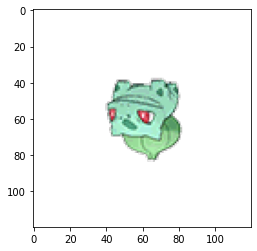

In [47]:
new_images = np.apply_along_axis(np.flipud, 1, image_data)
plt.imshow(new_images[0])

In [49]:
new_image_data = np.concatenate((image_data, new_images), axis=0)
new_labels = np.concatenate((pokemon_labels.to_numpy(), pokemon_labels.to_numpy()), axis=0)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(new_image_data, new_labels, test_size=0.2)
y_train = np.asarray(y_train, dtype=np.float32)[:, :18]
y_test = np.asarray(y_test, dtype=np.float32)[:, :18]

In [52]:
history = cnn_model2.fit(X_train, y_train, epochs=250, validation_data=(X_test, y_test))

Epoch 1/250
41/41 [==============================] - 3s 64ms/step - loss: 2.6352 - categorical_accuracy: 0.4505 - val_loss: 2.0825 - val_categorical_accuracy: 0.5093
Epoch 2/250
41/41 [==============================] - 2s 44ms/step - loss: 2.3722 - categorical_accuracy: 0.4505 - val_loss: 2.0202 - val_categorical_accuracy: 0.5000
Epoch 3/250
41/41 [==============================] - 2s 50ms/step - loss: 2.2066 - categorical_accuracy: 0.4583 - val_loss: 1.9413 - val_categorical_accuracy: 0.5093
Epoch 4/250
41/41 [==============================] - 2s 56ms/step - loss: 2.0865 - categorical_accuracy: 0.4714 - val_loss: 1.9295 - val_categorical_accuracy: 0.5000
Epoch 5/250
41/41 [==============================] - 2s 48ms/step - loss: 2.0234 - categorical_accuracy: 0.4722 - val_loss: 1.9075 - val_categorical_accuracy: 0.5000
Epoch 6/250
41/41 [==============================] - 2s 46ms/step - loss: 2.0459 - categorical_accuracy: 0.4614 - val_loss: 1.9069 - val_categorical_accuracy: 0.5154
Epoc

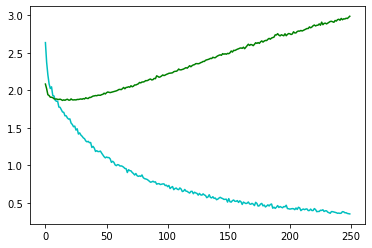

In [53]:
plt.figure(1)
plt.plot(range(250), history.history['loss'], color='c')
plt.plot(range(250), history.history['val_loss'], color='g')

plt.show()

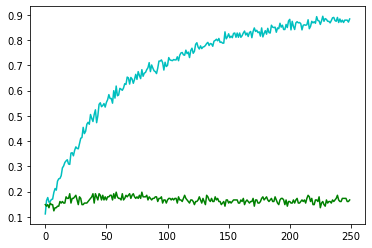

In [54]:
plt.figure(1)
plt.plot(range(250), history2.history['categorical_accuracy'], color='c')
plt.plot(range(250), history2.history['val_categorical_accuracy'], color='g')

plt.show()

# Task 2: Generation

## Load data

Source: [The Simpsons Characters Data](https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset)

This data is very large, so I can't push it to Github. Please use the source link to access the data and run my notebook. My notebook uses a .npy, which I included a script for creating in the repository.

In [3]:
simpsons_data = np.load(data_access + 'simpsons_data.npy', mmap_mode='r')

In [4]:
train_size = int(0.9 * len(simpsons_data))
test_size = len(simpsons_data) - train_size

train_dataset = (tf.data.Dataset.from_tensor_slices(simpsons_data[:train_size])
                 .shuffle(train_size).batch(100))
test_dataset = (tf.data.Dataset.from_tensor_slices(simpsons_data[train_size:])
                .shuffle(test_size).batch(100))

## Variational Autoencoder (VAE)

Source: [Convolutional Variational Autoencoder](https://www.tensorflow.org/tutorials/generative/cvae)

In [5]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(120, 120, 3)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=30*30*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(30, 30, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=3, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [77]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [78]:
epochs = 5
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [79]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [80]:
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 5, Test set ELBO: -27329.580078125, time elapse for current epoch: 586.446417093277


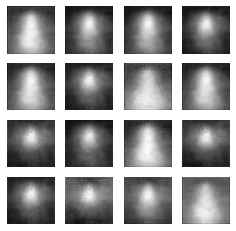

In [81]:
from IPython import display
import time

generate_and_save_images(model, 0, test_sample)
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, tf.cast(train_x, dtype=tf.float32), optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, tf.cast(test_x, dtype=tf.float32)))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

The final results take the shape of simpsons characters, but don't make out the facial features. (I accidentally showed the images in greyscale, so color isn't taken into account). The total training time of the model for 5 epochs is around 50min.

## Generative Adversial Network (GAN)

Couldn't get it to perform well in time (training takes too long to continue improving)

In [126]:
# GAN Model
class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()
        start_filters = 256
        self.deconv1 = tf.keras.layers.Conv2DTranspose(start_filters, (5, 5), activation='relu')
        self.batch_norm1 = tf.keras.layers.BatchNormalization()
        self.deconv2 = tf.keras.layers.Conv2DTranspose(start_filters/2, (5, 5), strides=(2, 2), padding='same', activation='relu')
        self.batch_norm2 = tf.keras.layers.BatchNormalization()
        self.deconv3 = tf.keras.layers.Conv2DTranspose(start_filters/4, (5, 5), strides=(4, 4), padding='same', activation='relu')
        self.batch_norm3 = tf.keras.layers.BatchNormalization()
        self.deconv4 = tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(3, 3), padding='same', activation='tanh')

    def call(self, inputs, training=False):
        output = self.deconv1(inputs)
        output = self.batch_norm1(output, training=training)
        output = self.deconv2(output)
        output = self.batch_norm2(output, training=training)
        output = self.deconv3(output)
        output = self.batch_norm3(output, training=training)
        output = self.deconv4(output)

        return output

class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        start_filters = 64
        self.conv1 = tf.keras.layers.Conv2D(start_filters, (2, 2), (2, 2))
        self.batch_norm1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(start_filters*2, (2, 2), strides=(2, 2), padding='same')
        self.batch_norm2 = tf.keras.layers.BatchNormalization()
        self.conv3 = tf.keras.layers.Conv2D(start_filters*4, (2, 2), strides=(2, 2), padding='same')
        self.batch_norm3 = tf.keras.layers.BatchNormalization()
        self.flatten = tf.keras.layers.Flatten()
        self.output_layer = tf.keras.layers.Dense(1, activation='sigmoid')
        self.leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.1)

    def call(self, inputs, training=False):
        start_filters = 64
        output = self.conv1(inputs)
        output = self.leaky_relu(output)
        output = self.batch_norm1(output, training=training)
        output = self.conv2(output)
        output = self.leaky_relu(output)
        output = self.batch_norm2(output, training=training)
        output = self.conv3(output)
        output = self.leaky_relu(output)
        output = self.batch_norm3(output, training=training)
        output = self.flatten(output)
        output = self.output_layer(output)

        return output       

class GAN(tf.keras.Model):
    def __init__(self):
        super(GAN, self).__init__()
        self.generator = Generator()
        self.discriminator = Discriminator()
        self.data_size = 100

    def compile(self, dis_optimizer, gen_optimizer, loss):
        super(GAN, self).compile(loss=loss)
        self.dis_optimizer = dis_optimizer
        self.gen_optimizer = gen_optimizer

    def train_step(self, inputs):
        # Create random input noise for generator based on d=100
        input_noise = np.random.rand(self.data_size*100)
        input_noise = tf.cast(tf.reshape(input_noise, (self.data_size, 1, 1, 100)), dtype=tf.float32)

        # Run forward and loss computation with gradient tape
        with tf.GradientTape() as dis_tape, tf.GradientTape() as gen_tape:
            fake_images = self.generator(input_noise, training=True)

            real_pred = self.discriminator(inputs, training=True)
            fake_pred = self.discriminator(fake_images, training=True)

            gen_loss = self.compiled_loss(tf.ones(self.data_size, 1), fake_pred)
            dis_loss = self.compiled_loss(tf.concat((tf.ones(self.data_size, 1), tf.zeros(self.data_size, 1)), axis=0), tf.concat((real_pred, fake_pred), axis=0))

        # Run backward prop with tape and trainable variables on discriminator
        dis_gradients = dis_tape.gradient(dis_loss, self.discriminator.trainable_variables)
        self.dis_optimizer.apply_gradients(zip(dis_gradients, self.discriminator.trainable_variables))

        # Run backward prop on generator
        gen_gradients = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(gen_gradients, self.generator.trainable_variables))

        return {"dis_loss": dis_loss, "gen_loss": gen_loss}

In [131]:
gan_model = GAN()

gan_model.compile(
    dis_optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.5),
    gen_optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.5),
    loss='binary_crossentropy'
)

In [132]:
new_train = (tf.data.Dataset.from_tensor_slices(simpsons_data[:18100])
                 .shuffle(train_size).batch(100))
new_test = (tf.data.Dataset.from_tensor_slices(simpsons_data[18195:])
                .shuffle(test_size).batch(100))

In [133]:
history = gan_model.fit(new_train, batch_size=100, epochs=2)

Epoch 1/2
181/181 [==============================] - 990s 5s/step - dis_loss: 7.5814 - gen_loss: 0.0207
Epoch 2/2
181/181 [==============================] - 1011s 6s/step - dis_loss: 7.6247 - gen_loss: 5.9679e-16


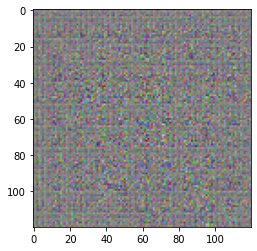

In [136]:
# Model does not work well, discriminator performs too poorly for
# generator to learn how to generate images correctly

# Generate random image to test
z_input = np.random.rand(100)
z_input = tf.cast(tf.reshape(z_input, (1, 1, 1, 100)), dtype=tf.float32)
gen_images = gan_model.generator(z_input)
gen_image = (gen_images[0] + 1) / 2.0
plt.imshow(gen_image)